Imports

In [54]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
from google.colab import drive
import seaborn as sns



Data Preprocessing

In [55]:
drive.mount('/content/drive')

source_dir = "/content/drive/MyDrive/avocado_prices.csv"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
avocado_sales_dataset = pd.read_csv(source_dir, parse_dates=True, index_col=1)
avocado_sales_dataset = avocado_sales_dataset.drop(avocado_sales_dataset.columns[0], axis=1)


In [76]:
avocado_sales_dataset.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [77]:
avocado_sales_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18249 entries, 2015-12-27 to 2018-01-07
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AveragePrice  18249 non-null  float64
 1   Total Volume  18249 non-null  float64
 2   4046          18249 non-null  float64
 3   4225          18249 non-null  float64
 4   4770          18249 non-null  float64
 5   Total Bags    18249 non-null  float64
 6   Small Bags    18249 non-null  float64
 7   Large Bags    18249 non-null  float64
 8   XLarge Bags   18249 non-null  float64
 9   type          18249 non-null  object 
 10  year          18249 non-null  int64  
 11  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(2)
memory usage: 1.8+ MB


In [82]:

averaged_data = avocado_sales_dataset.groupby(['Date', 'region']).agg({
    'AveragePrice': 'mean',
    'Total Volume': 'mean',
    'Total Bags': 'mean',
    'Small Bags': 'mean',
    'Large Bags': 'mean'
}).reset_index()

averaged_data.head()
averaged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9126 entries, 0 to 9125
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          9126 non-null   datetime64[ns]
 1   region        9126 non-null   object        
 2   AveragePrice  9126 non-null   float64       
 3   Total Volume  9126 non-null   float64       
 4   Total Bags    9126 non-null   float64       
 5   Small Bags    9126 non-null   float64       
 6   Large Bags    9126 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 499.2+ KB


In [83]:
averaged_data.set_index('Date', inplace=True)

In [61]:


grouped_data = averaged_data.groupby(['Date', 'type'])['AveragePrice'].mean().unstack()
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data)
plt.title('Average Price of Avocados by Type and Date')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()


KeyError: 'type'

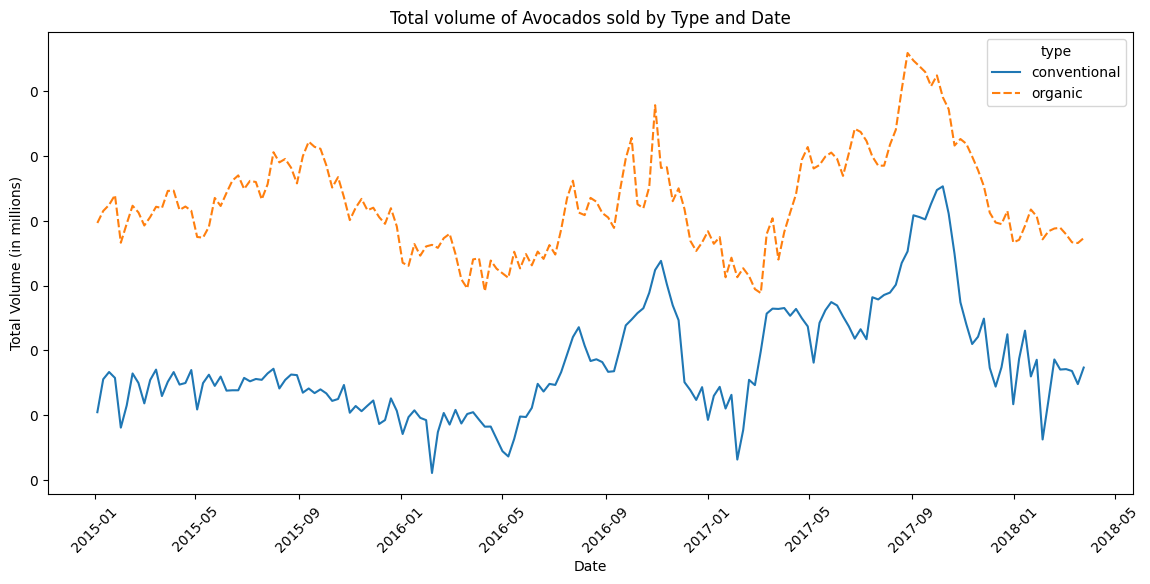

In [ ]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=grouped_data)
plt.title('Total volume of Avocados sold by Type and Date')
plt.xlabel('Date')
plt.ylabel('Total Volume (in millions)')  # Adjust ylabel
plt.xticks(rotation=45)

# Customize y-axis tick labels to display in millions
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:.0f}'.format(x / 10000)))

plt.show()

In [ ]:
def encode_columns(dataset, columnName):
    dummies = pd.get_dummies(dataset[columnName])

    for dummy in dummies.columns:
        dummy_name = f"{columnName}-{dummy}"
        dataset[dummy_name] = dummies[dummy]
    dataset.drop(columnName, axis=1, inplace=True)

In [ ]:
encode_columns(averaged_data,"type")
encode_columns(averaged_data,"region")

KeyError: 'type'

In [84]:
averaged_data.head()

,region,AveragePrice,Total Volume,Total Bags,Small Bags,Large Bags
Date,,,,,,
2015-01-04,Albany,1.505,21123.615,5439.555,5174.790,264.765
2015-01-04,Atlanta,1.380,219434.090,24111.990,8889.250,15222.740
2015-01-04,BaltimoreWashington,1.185,403581.170,72509.185,70513.880,1995.305
2015-01-04,Boise,1.325,40769.720,4064.985,3125.485,939.500
2015-01-04,Boston,1.425,246965.065,44453.585,44325.440,128.145


In [85]:
averaged_data = averaged_data.drop(columns=['region'])

In [86]:

trainSize = int(0.8 * len(averaged_data))
validationSize = int(0.1 * len(averaged_data))


In [87]:
train_set = averaged_data.iloc[:trainSize]
test_set = averaged_data.iloc[trainSize:]
validation_set = test_set.iloc[:validationSize]
test_set = test_set.iloc[validationSize:]

In [88]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7300 entries, 2015-01-04 to 2017-08-06
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AveragePrice  7300 non-null   float64
 1   Total Volume  7300 non-null   float64
 2   Total Bags    7300 non-null   float64
 3   Small Bags    7300 non-null   float64
 4   Large Bags    7300 non-null   float64
dtypes: float64(5)
memory usage: 342.2 KB


In [139]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)

endog = train_set['AveragePrice']
model = SARIMAX(endog, order=my_order, seasonal_order=my_seasonal_order)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [140]:
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 3.95216965675354


In [123]:
print(model_fit.summary())


                                      SARIMAX Results                                       
Dep. Variable:                         AveragePrice   No. Observations:                 7300
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood               77314.917
Date:                              Sat, 04 May 2024   AIC                        -154621.833
Time:                                      11:31:26   BIC                        -154594.251
Sample:                                           0   HQIC                       -154612.349
                                             - 7300                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
AveragePrice     1.0000         -0       -inf      0.000       1.000       1.000
ar.S.L12     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3014: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3014: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1420: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [143]:
predictions = model_fit.forecast(steps=len(test_set))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [144]:
# predictions = pd.Series(predictions, index=test_set.index)
print(predictions)


7300    1.794015
7301    1.687499
7302    1.816170
7303    1.780070
7304    1.763484
          ...   
8209    1.839239
8210    1.839239
8211    1.839239
8212    1.839239
8213    1.839239
Name: predicted_mean, Length: 914, dtype: float64


In [145]:
file_path = "price prediction_model.pkl"
model_fit.save(file_path)

In [147]:
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

print("Forecasted prices for the next {} periods:".format(forecast_steps))
print(forecast)

Forecasted prices for the next 10 periods:
7300    1.794015
7301    1.687499
7302    1.816170
7303    1.780070
7304    1.763484
7305    1.860651
7306    1.767692
7307    1.683591
7308    1.818981
7309    1.864071
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
